In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from ray.tune import Analysis
from src.data import IFCNetPly
from src.models.models import DGCNN
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
import torch.nn as nn
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/DGCNN/IFCNetCore")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetPly(data_root, class_names, partition="train")
val_dataset = IFCNetPly(data_root, class_names, partition="train")
test_dataset = IFCNetPly(data_root, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=8, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=8)

In [5]:
log_dir = Path("../logs/DGCNN/DEFAULT_2021-03-03_09-24-56//")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

In [6]:
with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

model = DGCNN(config["dropout"], config["k"], config["embedding_dim"], len(class_names))
model_state, _ = torch.load(best_trial_dir/"checkpoint_249"/"checkpoint")
model.load_state_dict(model_state)

<All keys matched successfully>

In [7]:
device = torch.device("cuda")
model.eval()
model.to(device)

DGCNN(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [8]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(loader):
            data, labels = data.to(device), labels.to(device)
            data = data.permute(0, 2, 1)

            outputs = model(data)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    print(result)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 486/486 [01:42<00:00,  4.75it/s]


{'accuracy_score': 0.8921492921492922, 'balanced_accuracy_score': 0.8841693024249693, 'precision_score': 0.898975558044042, 'recall_score': 0.8921492921492922, 'f1_score': 0.8923964022259425}


(array([ 0,  0,  0, ..., 19, 19, 19]),
 array([[0.6302511 , 0.01714174, 0.005175  , ..., 0.0130059 , 0.01076412,
         0.01267116],
        [0.84208566, 0.01156599, 0.00283637, ..., 0.0072281 , 0.01478207,
         0.00195627],
        [0.26796672, 0.31992862, 0.00549665, ..., 0.01549913, 0.02951859,
         0.01366005],
        ...,
        [0.03258472, 0.04260628, 0.00463205, ..., 0.010671  , 0.01331458,
         0.40942213],
        [0.02483827, 0.02641878, 0.01144827, ..., 0.02062387, 0.01220972,
         0.45275313],
        [0.02195767, 0.03046216, 0.0179004 , ..., 0.0099203 , 0.01549431,
         0.19410549]], dtype=float32))

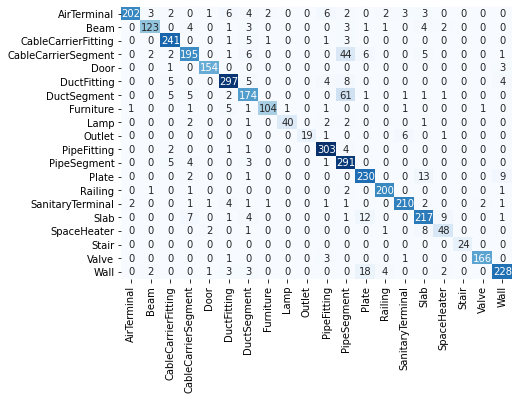

In [9]:
eval(model, train_loader, device, class_names)

100%|██████████| 209/209 [00:44<00:00,  4.72it/s]


{'accuracy_score': 0.8853541416566627, 'balanced_accuracy_score': 0.8886793195304536, 'precision_score': 0.8910656317962118, 'recall_score': 0.8853541416566627, 'f1_score': 0.8852214358321451}


(array([ 0,  0,  0, ..., 19, 19, 19]),
 array([[0.22166972, 0.05158373, 0.01920485, ..., 0.01038348, 0.01228437,
         0.04070494],
        [0.5509907 , 0.02664514, 0.00438504, ..., 0.01914506, 0.00590698,
         0.06523681],
        [0.02878604, 0.01586658, 0.03312337, ..., 0.01117809, 0.01679055,
         0.01089933],
        ...,
        [0.01660099, 0.01965397, 0.00398681, ..., 0.01051739, 0.00481717,
         0.559611  ],
        [0.00969875, 0.01055223, 0.01079919, ..., 0.00667382, 0.00628071,
         0.68661124],
        [0.00642032, 0.01258607, 0.00695609, ..., 0.01415458, 0.00687824,
         0.61672145]], dtype=float32))

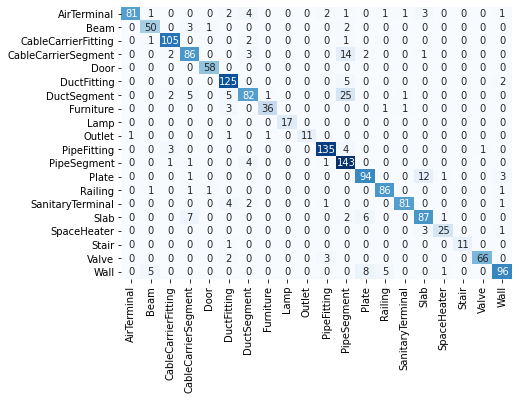

In [10]:
eval(model, val_loader, device, class_names)

100%|██████████| 298/298 [01:02<00:00,  4.73it/s]


{'accuracy_score': 0.8230348886086591, 'balanced_accuracy_score': 0.7910900935195901, 'precision_score': 0.8325858690505255, 'recall_score': 0.8230348886086591, 'f1_score': 0.8215339559622226}


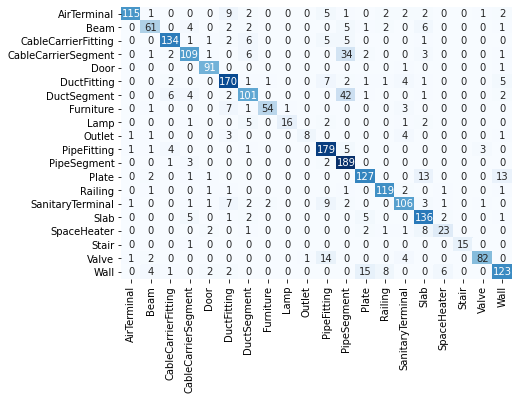

In [11]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/dgcnn_confusion.png")

In [12]:
np.savez("DGCNNProbs.npz", labels=test_labels, probs=test_probs)

In [13]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [14]:
wrong_pred_dir = Path("../data/external/DGCNN/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.files[i].stem}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.files[i]
    shutil.copy(str(raw_data_dict[filename.stem]), str(target_dir / f"{filename.stem}_{prediction_str}.obj"))

0040c7bf0e474141bb19bdf8ed59e080, Label: IfcAirTerminal, Prediction: IfcBeam
074813d22a894bd299966b7fb2163749, Label: IfcAirTerminal, Prediction: IfcDuctSegment
334a4570ea2c44748251140812d50117, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
3df6f5ef06c44a8685ec8db23d695b01, Label: IfcAirTerminal, Prediction: IfcDuctFitting
5bfd5d508e084fa6a436046276beb8df, Label: IfcAirTerminal, Prediction: IfcSlab
5c4c4a4d2a11431b92a19b0313f8ea68, Label: IfcAirTerminal, Prediction: IfcPipeFitting
71059417b8f4400ca102c84ae1a0f421, Label: IfcAirTerminal, Prediction: IfcSlab
758d8037f82e4ac0a7ff1b112df40ac3, Label: IfcAirTerminal, Prediction: IfcRailing
7a225741d47f444a949229e262a9c086, Label: IfcAirTerminal, Prediction: IfcDuctFitting
7abfdf8a14054b8faed65bd520001e2d, Label: IfcAirTerminal, Prediction: IfcDuctFitting
7ac5c781e86644d1a9e95b8e2db000b0, Label: IfcAirTerminal, Prediction: IfcDuctFitting
923040fc07114eea990b70d042cfab18, Label: IfcAirTerminal, Prediction: IfcPipeSegment
93e8e74fbf00